# Image colorization using [CNN] Autoencoders

In this notebook, we will go through building a machine learning model that leverages the power of Autoencoders in colorizing black&white or grayscale images. 

In [1]:
# import required libraries
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer
from tensorflow.keras.models import Sequential, Model
from skimage.color import rgb2lab, lab2rgb, rgb2gray

print(tf.__version__)

2.11.0


# 1. Data preparation

In [2]:
# create a generator and get the images from the directory
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
seed = 10
images_set = img_generator.flow_from_directory(
    '/kaggle/input/image-colorization-dataset/data/',
    seed=seed,
    batch_size=64,
)

Found 11478 images belonging to 4 classes.


Totally, there are **11478** images in this dataset. 5000 of the images are the training set (X), 5000 of them are the training set (Y). and the rest is the validation set. That is, we have 5000 color images and 5000 grayscale forms.<br>
However, I will not use the grayscale images of the dataset; instead, I will convert the color images to grayscale images because that is easier to manage. Also, we will only use 4000 images for training since we don't have enough memory.

In [3]:
# collect 4000 images for training and 500 images for testing

color_images_train = []
color_images_test = []
n_train = 4500
n_test = 500
for i, batch in enumerate(images_set):
    # extract images which belongs to 'test_color' directory: used for test set
    color_img_batch_test = batch[0][np.argmax(batch[1], axis=1) == 1]
    # extract images which belongs to 'train_color' directory: used for training set
    color_img_batch_train = batch[0][np.argmax(batch[1], axis=1) == 3]
    
    # append training images to training set
    if len(color_images_train) < n_train:
        for img in color_img_batch_train:
            color_images_train.append(img)
    # append test images to test set
    if len(color_images_test) < n_test:
        for img in color_img_batch_test:
            color_images_test.append(img)
    if i % 10==0:
        print(f'Batch {i}')
        
    # enough images captured
    if len(color_images_train) >= n_train and len(color_images_test) >= n_test:
        break
        
color_images_train = np.array(color_images_train)[:n_train]
display(color_images_train.shape)
color_images_test = np.array(color_images_test)[:n_test]
display(color_images_test.shape)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110
Batch 120
Batch 130
Batch 140
Batch 150
Batch 160


(4500, 256, 256, 3)

(500, 256, 256, 3)

In [4]:
import gc # garbage collection: used to free memory space by removing garbage
gc.collect()

73

We will use LAB color space instead of RGB because of the following reason:<br>
L in LAB is indeed the grayscale form of the image, and its values are between 0 and 100. AB in LAB are the rest of colors that makes a colorful image when added to L. AB values are between -128 to 128. We will normalize them later.<br>
If we use RGB, we have to use all three channels (RGB) as Y, but using LAB colorspace enable us to get the L as X and AB as Y, which makes it easier to learn. That is, in RGB we value to predict three values for each pexil, wherease when using LAB, we only need to predict two values for each pexil.

In [5]:
# utils

# Preprocess the dataset
def preprocess_dataset(images):
    # convert the images from rgb to lab color space
    images_lab = [rgb2lab(image) for image in images]
    images_lab = np.array(images_lab)
    
    # Split into L and AB channels
    X = images_lab[:, :, :, 0]
    Y = images_lab[:, :, :, 1:]
    
    # Normalize L channel to [-1, 1]
    X = X / 50 - 1
    X = X.reshape(X.shape + (1,))

    # Normalize AB channels to [-1, 1]
    Y = Y / 128
    return X, Y

# Predict the colorized image
def colorize(autoencoder, X):
    Y_pred = autoencoder.predict(X)
    # re-transform normalization: change back from [-1, 1] to [-128, 128]
    Y_pred = Y_pred * 128 
    colorized_images = np.zeros((X.shape[0], 256, 256, 3))
    for i in range(X.shape[0]):
        # re-transform normalization: change back from [-1, 1] to [0, 100]
        l = X[i][:, :, 0] * 50 + 50 
        ab = Y_pred[i]
        colorized_images[i] = np.concatenate((l[:, :, np.newaxis], ab), axis=2)
        colorized_images[i] = lab2rgb(colorized_images[i])
    return colorized_images

In [6]:
# prepare/preprocess the training and test sets
X_train, Y_train = preprocess_dataset(color_images_train)
X_test, Y_test = preprocess_dataset(color_images_test)

In [7]:
# delete redundant variables to free some memory 
del color_images_train, color_images_test
gc.collect()

42

# 2. Modeling | Training and evaluation

In [8]:
# define Autoencoder class
class Autoencoder:
    def __init__(self, input_shape=(256, 256, 1)):
        self.input_shape = input_shape
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.autoencoder = self.build_autoencoder()

    def build_encoder(self):
        model = Sequential()
        model.add(InputLayer(input_shape=self.input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        return model

    def build_decoder(self):
        model = Sequential()
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(4, (3, 3), activation='tanh', padding='same'))
        model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
        model.add(UpSampling2D((2, 2)))
        return model

    def build_autoencoder(self):
        inputs = tf.keras.Input(shape=self.input_shape)
        x = self.encoder(inputs)
        outputs = self.decoder(x)
        return Model(inputs=inputs, outputs=outputs)

# instantiate the class: and build the model's structure
autoencoder = Autoencoder().autoencoder

In [9]:
# compile and train the model
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='mse')
history = autoencoder.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size = 32,
    epochs=32
)

Epoch 1/32
141/141 [==============================] - 46s 218ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 2/32
141/141 [==============================] - 27s 189ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 3/32
141/141 [==============================] - 27s 188ms/step - loss: 0.0125 - val_loss: 0.0126
Epoch 4/32
141/141 [==============================] - 27s 189ms/step - loss: 0.0124 - val_loss: 0.0125
Epoch 5/32
141/141 [==============================] - 26s 188ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 6/32
141/141 [==============================] - 27s 188ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 7/32
141/141 [==============================] - 27s 188ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 8/32
141/141 [==============================] - 27s 189ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 9/32
141/141 [==============================] - 27s 188ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 10/32
141/141 [==============================] - 26s 188ms/step - l

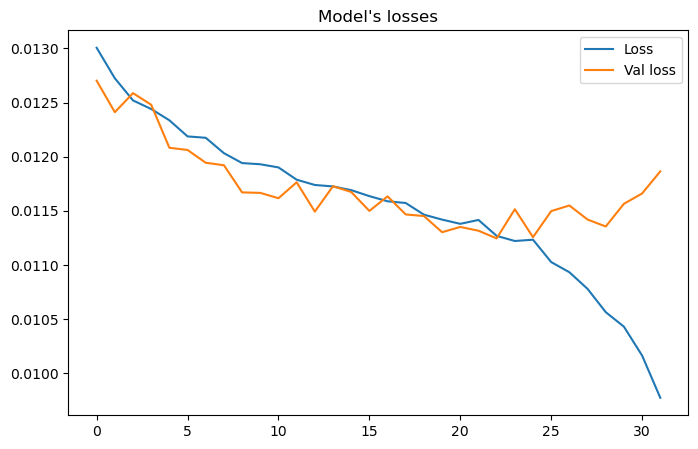

In [10]:
# visualize the losses of the model
loss =  history.history.get('loss')
val_loss = history.history.get('val_loss')

plt.figure(figsize=(8, 5))

plt.title('Model\'s losses')
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Loss', 'Val loss'])
plt.show()

In [11]:
# do prediction on the test set: used for data visualization bellow
preds = colorize(autoencoder, X_test)

16/16 [==============================] - 1s 51ms/step


/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


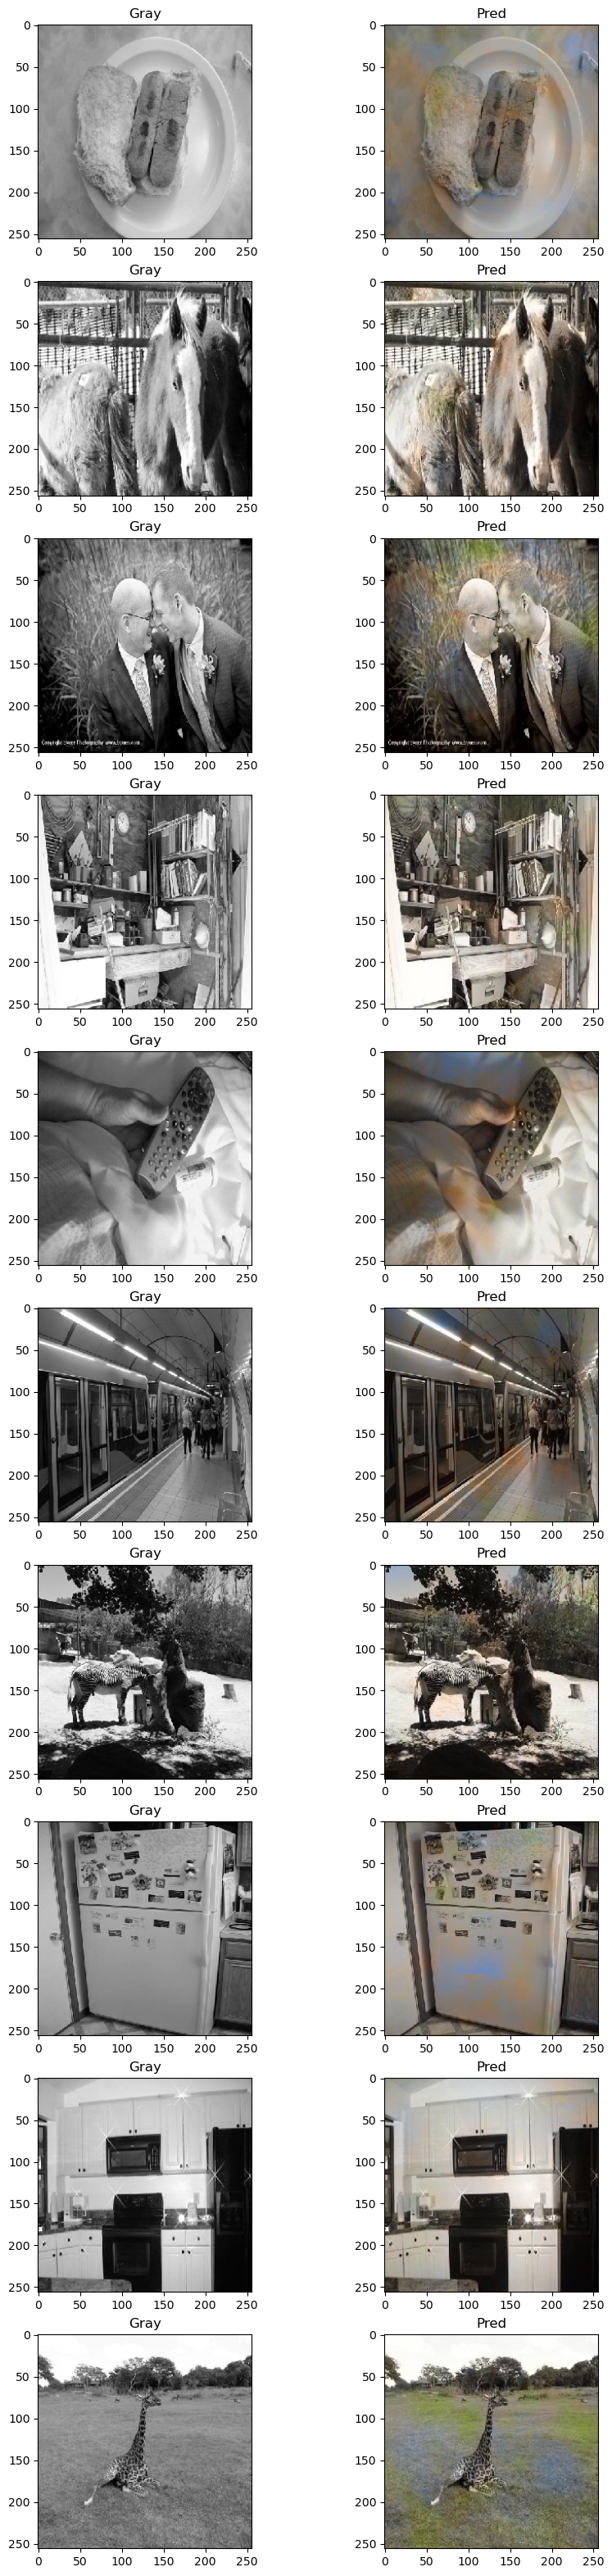

In [12]:
# visualize some results from the test set.
plt.figure(figsize=(10, 40))
s, e = 8, 18
index = 1
for i, j in zip(X_test[s:e], preds[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i, cmap='gray')
    plt.title('Gray')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j)
    plt.title('Pred')
    index += 2

In [13]:
# save the model
autoencoder.save('./img-colorization-model')

In [14]:
# zip the model
!zip -r img-colorization-model.zip img-colorization-model

  adding: img-colorization-model/ (stored 0%)
  adding: img-colorization-model/variables/ (stored 0%)
  adding: img-colorization-model/variables/variables.index (deflated 70%)
  adding: img-colorization-model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: img-colorization-model/keras_metadata.pb (deflated 96%)
  adding: img-colorization-model/assets/ (stored 0%)
  adding: img-colorization-model/saved_model.pb (deflated 90%)
  adding: img-colorization-model/fingerprint.pb (stored 0%)


# Thank you:)